# Working With Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
# configure matplotlib output
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
%matplotlib inline

In [3]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [4]:
# some warnings can get annoying
import warnings
warnings.filterwarnings('ignore')

# Pandas!

## DataFrame

In [5]:
# a Series is a 1d array with an attached index (defaults to range(n))
s = pd.Series(np.random.rand(10), index=np.arange(10, 20))
s

10    0.717944
11    0.081906
12    0.695038
13    0.527775
14    0.974576
15    0.758653
16    0.980410
17    0.618018
18    0.204896
19    0.422650
dtype: float64

In [6]:
# let's look at the underlying data
print(s.index)
print(s.values)

Int64Index([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='int64')
[0.71794444 0.08190648 0.69503811 0.52777463 0.97457563 0.75865313
 0.98040979 0.6180177  0.20489623 0.42264995]


In [7]:
# get a quick summary of a numeric series
s.describe()

count    10.000000
mean      0.598187
std       0.297139
min       0.081906
25%       0.448931
50%       0.656528
75%       0.748476
max       0.980410
dtype: float64

In [8]:
# a DataFrame is like a dictionary of Series with a common index
df = pd.DataFrame({'ser1': s, 'ser2': np.random.randn(10)})
df.head()

,ser1,ser2
10,0.717944,-1.460389
11,0.081906,1.680789
12,0.695038,0.524033
13,0.527775,-0.822692
14,0.974576,-0.022186


In [9]:
# get summary stats for each column
df.describe()

,ser1,ser2
count,10.000000,10.000000
mean,0.598187,-0.237297
std,0.297139,1.077363
min,0.081906,-1.460389
25%,0.448931,-0.954786
50%,0.656528,-0.501030
75%,0.748476,0.387478
max,0.980410,1.680789


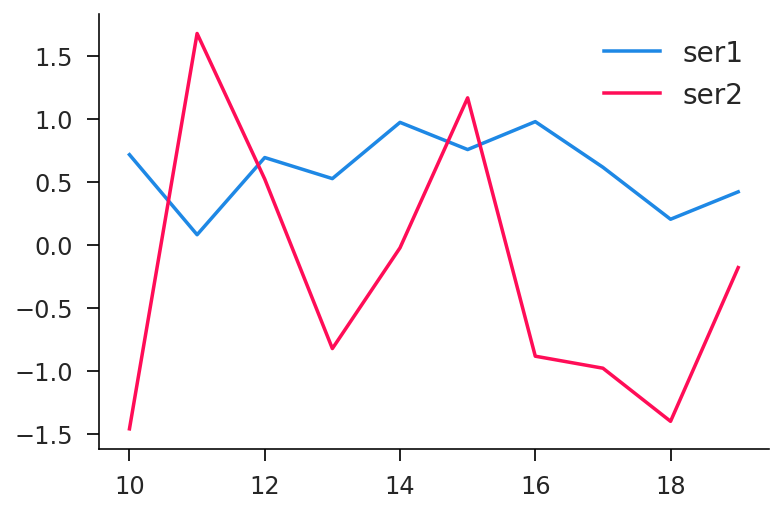

In [10]:
# much easier as a plotting interface
df.plot();

In [11]:
# accessing individual columns yields a Series
df['ser1']

10    0.717944
11    0.081906
12    0.695038
13    0.527775
14    0.974576
15    0.758653
16    0.980410
17    0.618018
18    0.204896
19    0.422650
Name: ser1, dtype: float64

In [12]:
# we can perform vector operations on these
df['ser1'] > 0.5

10     True
11    False
12     True
13     True
14     True
15     True
16     True
17     True
18    False
19    False
Name: ser1, dtype: bool

In [13]:
# we can select particular rows in this way
df1 = df[df['ser1']>0.5]
df1

,ser1,ser2
10,0.717944,-1.460389
12,0.695038,0.524033
13,0.527775,-0.822692
14,0.974576,-0.022186
15,0.758653,1.169468
16,0.980410,-0.883233
17,0.618018,-0.978637


In [14]:
# an alternative way to select rows
df.query('ser1 > 0.5')

,ser1,ser2
10,0.717944,-1.460389
12,0.695038,0.524033
13,0.527775,-0.822692
14,0.974576,-0.022186
15,0.758653,1.169468
16,0.980410,-0.883233
17,0.618018,-0.978637


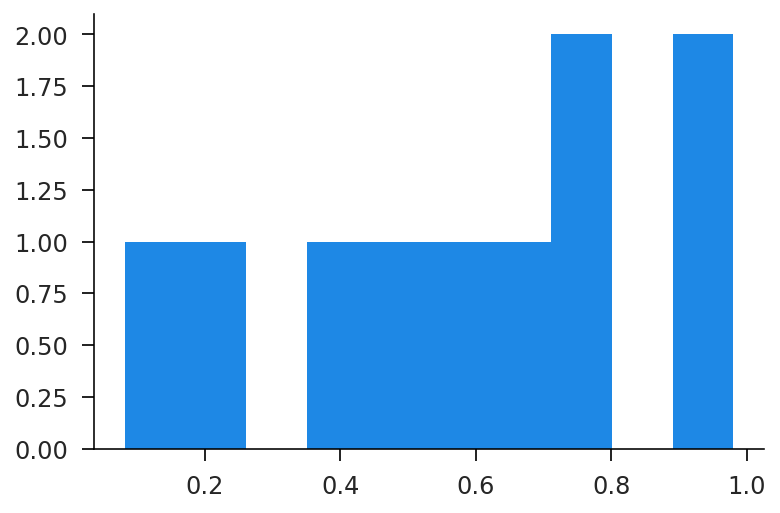

In [15]:
# includes other plotting options such as histograms
df['ser1'].hist(grid=False);

## Grouping Data

In [16]:
# make some fake data
N = 100
block = np.random.randint(4, size=N)
cmean = np.array([0.1, 0.2, 0.3, 0.4])
cvars = np.array([0.2, 0.1, 0.5, 0.2])
value = cmean[block]+np.random.randn(N)*cvars[block]
df = pd.DataFrame({
    'block': block,
    'value': value
})

In [17]:
# get the first 10 rows
df.head(10)

,block,value
0,0,-0.119187
1,3,0.427736
2,3,0.502555
3,3,0.571289
4,2,-0.502475
5,1,0.315397
6,1,0.089433
7,3,0.507426
8,0,0.230840
9,3,0.701206


In [18]:
# get value counts of "block"
df.groupby('block').size()

block
0    24
1    20
2    25
3    31
dtype: int64

In [19]:
# get means of "value" conditional on "block"
df.groupby('block')['value'].mean()

block
0    0.091352
1    0.152757
2    0.229761
3    0.395611
Name: value, dtype: float64

In [20]:
# get stdevs of "value" conditional on "block"
df.groupby('block')['value'].std()

block
0    0.155515
1    0.113284
2    0.473567
3    0.188884
Name: value, dtype: float64

In [21]:
# get a custom function conditional on "block" - here the mean absolute deviation
df.groupby('block')['value'].apply(lambda x: np.mean(np.abs(x-np.mean(x))))

block
0    0.112375
1    0.100932
2    0.378019
3    0.152748
Name: value, dtype: float64

In [22]:
# get all of these stats and group them together
grp = df.groupby('block')['value']
pd.DataFrame({
    'mean': grp.mean(),
    'stdv': grp.std(),
    'absd': grp.apply(lambda x: np.mean(np.abs(x-np.mean(x))))
})

,mean,stdv,absd
block,,,
0,0.091352,0.155515,0.112375
1,0.152757,0.113284,0.100932
2,0.229761,0.473567,0.378019
3,0.395611,0.188884,0.152748


## Time Series

In [23]:
# series parameters
ret = 0.05 # yearly return
vol = 0.1 # yearly volatility

In [24]:
# generate a daily index
days = pd.date_range('2016-01-01', '2016-12-31', freq='D')
N = len(days)
T = (days.max()-days.min()).days/365.25
delt = T/N

In [25]:
# construct a DataFrame with that
vals = vol*np.sqrt(delt)*np.cumsum(np.random.randn(N))
df = pd.DataFrame({
    'date': days,
    'price': vals
}).set_index('date')
df.head()

,price
date,
2016-01-01,0.005802
2016-01-02,0.001899
2016-01-03,0.003760
2016-01-04,0.016964
2016-01-05,0.016287


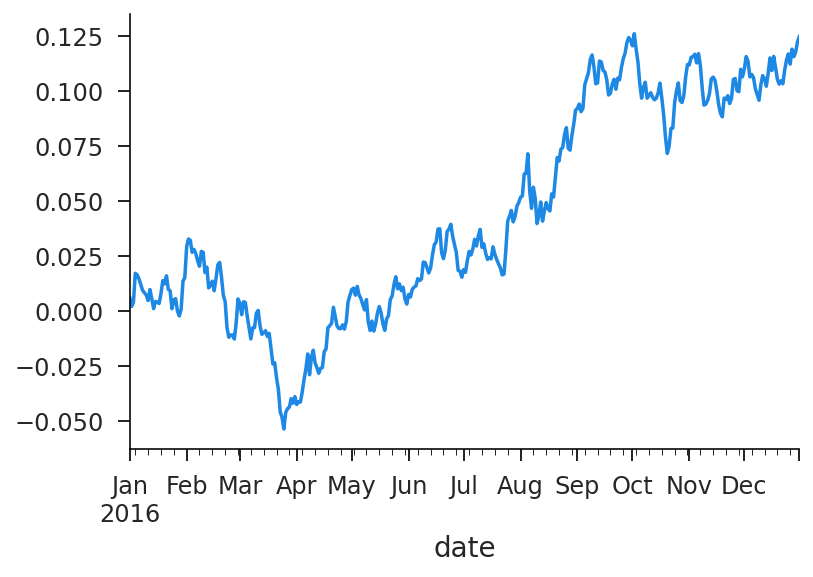

In [26]:
# plot the price - notice date-aware x-axis
df['price'].plot();

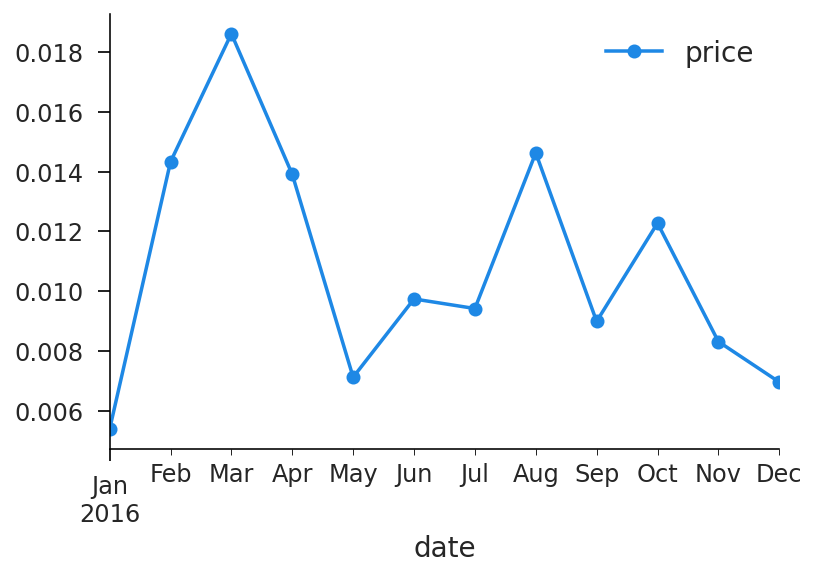

In [27]:
# groupby applied to a datetime index
df.groupby(pd.Grouper(freq='MS')).std().plot(marker='o');

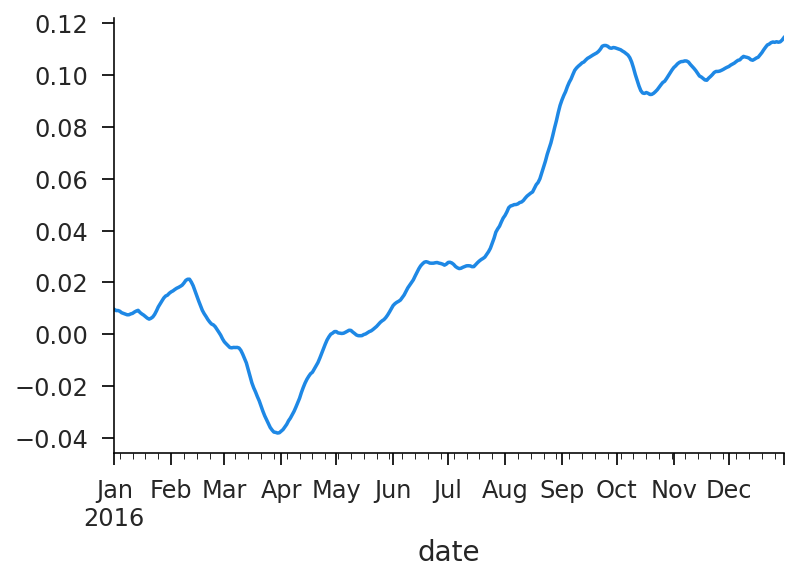

In [28]:
# convenient rolling mean functionality
df.rolling(20, center=True, min_periods=5).mean().plot(legend=False);

## Transforming

In [29]:
# series parameters
ret = 0.05 # yearly return
vol = 0.1 # yearly volatility

In [30]:
# generate another datetime index
days = pd.date_range('2006-01-01', '2016-12-31', freq='D')
N = len(days)
T = (days.max()-days.min()).days/365.25
delt = T/N

In [31]:
# construct the DataFrame
vals = vol*np.sqrt(delt)*np.cumsum(np.random.randn(len(days)))
df = pd.DataFrame({
    'date': days,
    'price': vals
}).set_index('date')

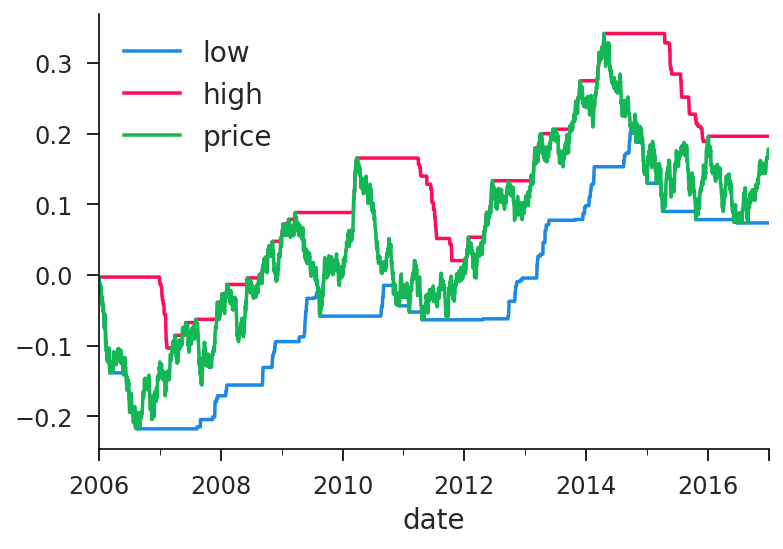

In [32]:
# are these bollinger bands? maybe
roll = df['price'].rolling(52*7, min_periods=1)
pd.DataFrame({
    'low' : roll.min(),
    'high': roll.max(),
    'price': df['price']
}).plot();

## Plotting

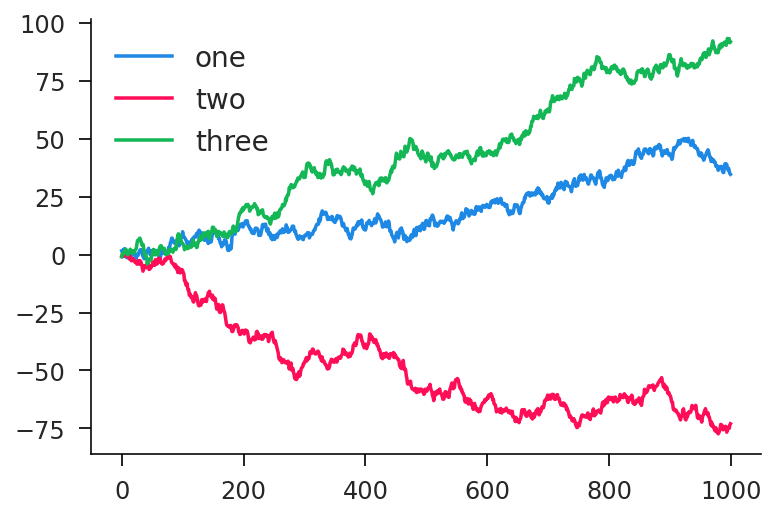

In [33]:
# good way to arrange plots
pd.DataFrame({
    'one': np.cumsum(np.random.randn(1000)),
    'two': np.cumsum(np.random.randn(1000)),
    'three': np.cumsum(np.random.randn(1000))
}).plot();

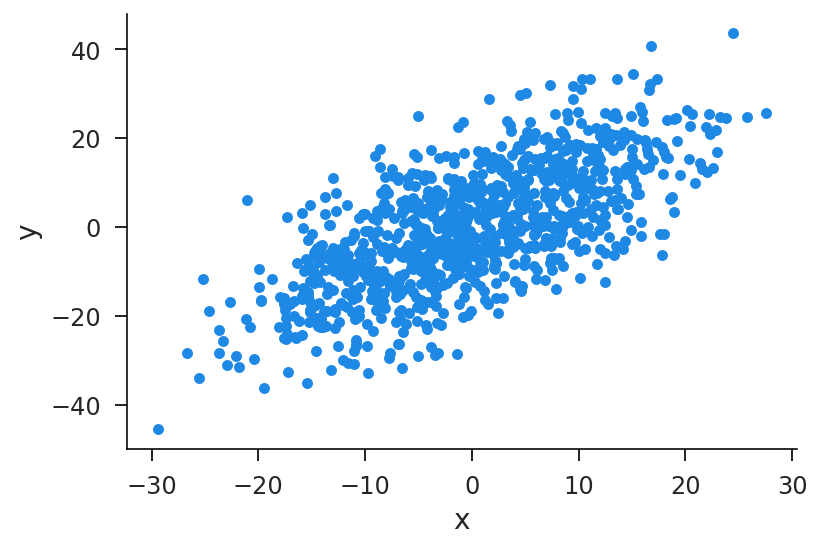

In [34]:
# we can also do scatter plots
x = 10*np.random.randn(1000)
y = x + 10*np.random.randn(1000)
df = pd.DataFrame({
    'x': x,
    'y': y
})
df.plot.scatter(x='x', y='y');

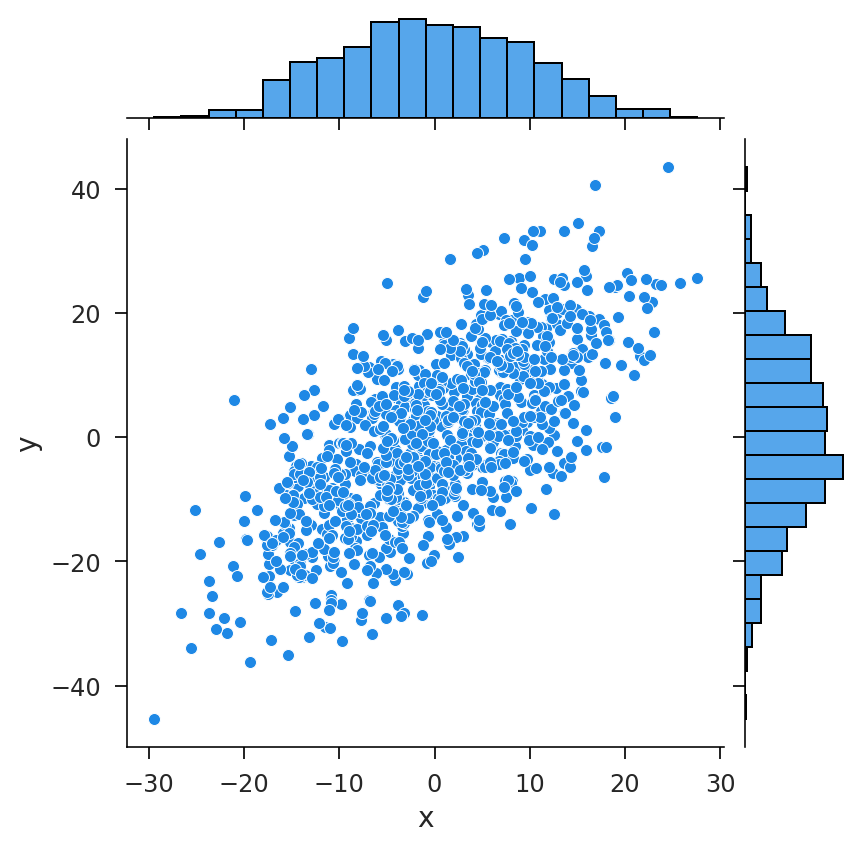

In [35]:
# seaborn has a lot of fancy plot interfaces that are DataFrame aware
sns.jointplot(x='x', y='y', data=df);

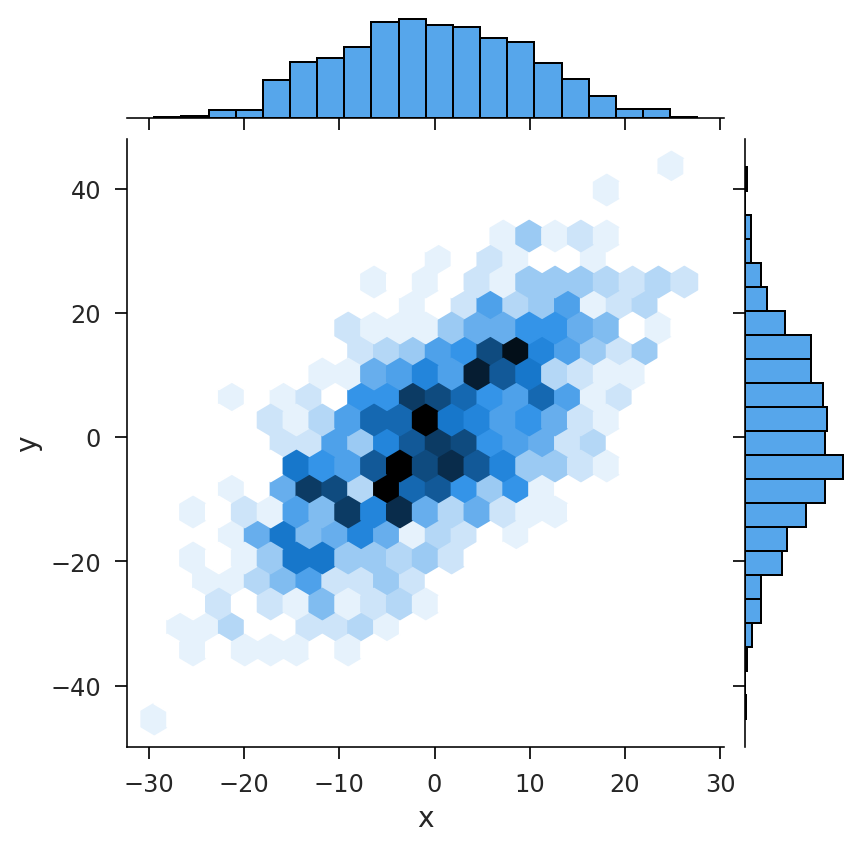

In [36]:
# kind in ['scatter', 'reg', 'resid', 'kde', 'hex']
sns.jointplot(x='x', y='y', kind='hex', data=df);

## Indexing

In [37]:
# another random DataFrame
df = pd.DataFrame({
    'a': np.arange(10),
    'b': np.random.rand(10)
}, index=np.arange(10, 20))
df

,a,b
10,0,0.494546
11,1,0.842061
12,2,0.460201
13,3,0.810336
14,4,0.212605
15,5,0.954058
16,6,0.848001
17,7,0.883713
18,8,0.617307
19,9,0.339233


In [38]:
# slicing on index
df.loc[14]

a    4.000000
b    0.212605
Name: 14, dtype: float64

In [39]:
# slicing on location
df.iloc[4]

a    4.000000
b    0.212605
Name: 14, dtype: float64

In [40]:
# selecting particular rows
df[df['a']>5]

,a,b
16,6,0.848001
17,7,0.883713
18,8,0.617307
19,9,0.339233


In [41]:
# advanced row selection
df[(df['a']>3)&(df['a']<8)]

,a,b
14,4,0.212605
15,5,0.954058
16,6,0.848001
17,7,0.883713


In [42]:
# querying interface
df.query('a > 3 and a < 8')

,a,b
14,4,0.212605
15,5,0.954058
16,6,0.848001
17,7,0.883713


## Joining

In [43]:
# a Series of x → 2x pairs
mapp = pd.Series({x: 2*x for x in range(10)}, name='twox')
mapp

0     0
1     2
2     4
3     6
4     8
5    10
6    12
7    14
8    16
9    18
Name: twox, dtype: int64

In [44]:
# yet more random data - one categorical, one continuous
init = pd.DataFrame({
    'ser': np.random.randint(10, size=100),
    'val': np.random.rand(100)
})
init.head()

,ser,val
0,1,0.473614
1,0,0.458161
2,1,0.204444
3,0,0.539284
4,3,0.733089


In [45]:
# with join we match the "ser" column to the index of "mapp"
final = init.join(mapp, on='ser')
final.head()

,ser,val,twox
0,1,0.473614,2
1,0,0.458161,0
2,1,0.204444,2
3,0,0.539284,0
4,3,0.733089,6


In [46]:
# assert that it worked
check = final['twox'] == 2*final['ser']
check.all()

True

### Stack and unstack (and some pivot)

In [47]:
# this constructs a family structure table
M, N = 5, 12
from itertools import cycle
cmap = list(zip(cycle(range(M)), range(100, 100+N), np.random.rand(N)))
pmap = pd.DataFrame(cmap, columns=['pid', 'cid', 'income'])
pmap = pmap.sort_values('pid').reset_index(drop=True)
pmap[['pid', 'cid']] = pmap[['pid', 'cid']].astype('Int64') # so we get integer nulls
pmap

,pid,cid,income
0,0,100,0.857866
1,0,105,0.166063
2,0,110,0.031674
3,1,101,0.398507
4,1,106,0.318202
5,1,111,0.182958
6,2,102,0.868372
7,2,107,0.780250
8,3,103,0.906670
9,3,108,0.923529


In [48]:
# tabulate the order of each child
pmap['order'] = pmap.groupby('pid').cumcount().apply(lambda x: f'child{x}')
ptab = pmap.set_index(['pid', 'order'])
ptab

cid    income
pid order                
0   child0  100  0.857866
    child1  105  0.166063
    child2  110  0.031674
1   child0  101  0.398507
    child1  106  0.318202
    child2  111  0.182958
2   child0  102  0.868372
    child1  107  0.780250
3   child0  103  0.906670
    child1  108  0.923529
4   child0  104  0.123959
    child1  109  0.046490

In [49]:
# reshape to wide form - notice multilevel column index
fam = ptab.unstack(level=1)
fam

cid                  income                    
order child0 child1 child2    child0    child1    child2
pid                                                     
0        100    105    110  0.857866  0.166063  0.031674
1        101    106    111  0.398507  0.318202  0.182958
2        102    107   <NA>  0.868372  0.780250       NaN
3        103    108   <NA>  0.906670  0.923529       NaN
4        104    109   <NA>  0.123959  0.046490       NaN

In [50]:
# the reverse operation gives us what we started with
fam.stack(level='order')

cid    income
pid order                
0   child0  100  0.857866
    child1  105  0.166063
    child2  110  0.031674
1   child0  101  0.398507
    child1  106  0.318202
    child2  111  0.182958
2   child0  102  0.868372
    child1  107  0.780250
3   child0  103  0.906670
    child1  108  0.923529
4   child0  104  0.123959
    child1  109  0.046490

In [51]:
# we can do this with pivot too (but nulls are d
pmap.pivot('pid', 'order', ['cid', 'income'])

cid                  income                    
order child0 child1 child2    child0    child1    child2
pid                                                     
0        100    105    110  0.857866  0.166063  0.031674
1        101    106    111  0.398507  0.318202  0.182958
2        102    107    NaN  0.868372   0.78025       NaN
3        103    108    NaN   0.90667  0.923529       NaN
4        104    109    NaN  0.123959   0.04649       NaN

## Input/Output

In [52]:
# generate random data and save to CSV
df = pd.DataFrame({
    'one': np.cumsum(np.random.randn(1000)),
    'two': np.cumsum(np.random.randn(1000)),
    'three': np.cumsum(np.random.randn(1000))
})
df.to_csv('output/series.csv', index=False)

In [53]:
!head output/series.csv

one,two,three
-0.6110387336799759,1.0380111214256562,1.1740610983222315
1.753213925347539,0.6726147122369871,1.9745196222034291
2.992119255587686,1.5142941004984642,1.4024380378746315
3.7783999114867055,-0.22511026940903522,0.7446230437660809
3.059757632350037,-0.11936392098854401,2.3449178698617033
3.319697781126752,-0.8705945565133439,2.275148589382504
5.061932016225772,-0.8075844747331332,2.7271855901069832
3.435991703144232,0.3661974001161249,3.192902168419562
2.4392172861252703,1.5231185287312128,4.11430337341237


In [54]:
# read it back into a DataFrame - this is the modern method
df = pd.read_csv('output/series.csv')
df.head()

,one,two,three
0,-0.611039,1.038011,1.174061
1,1.753214,0.672615,1.974520
2,2.992119,1.514294,1.402438
3,3.778400,-0.225110,0.744623
4,3.059758,-0.119364,2.344918


Can also use the many `pd.DataFrame.to_*` and `pd.read_*` function where `*` is one of:
- csv
- excel
- parquet
- json
- html
- latex
- stata
- sql

Parquet is relatively new and interesting! It is fast but not as heavy as SQL, but it also doesn't suffer from the same typing issues that CSV sometimes does.

## External Data

In [55]:
import pandas_datareader as pdr

In [56]:
emp = pdr.fred.FredReader(['UNRATE', 'LNS12300060'], start='1948-01-01').read()
emp = emp.rename(columns={'UNRATE': 'unemp', 'LNS12300060': 'empop'}).rename_axis('date')
emp.head()

,unemp,empop
date,,
1948-01-01,3.4,62.6
1948-02-01,3.8,62.7
1948-03-01,4.0,62.6
1948-04-01,3.9,62.9
1948-05-01,3.5,62.5


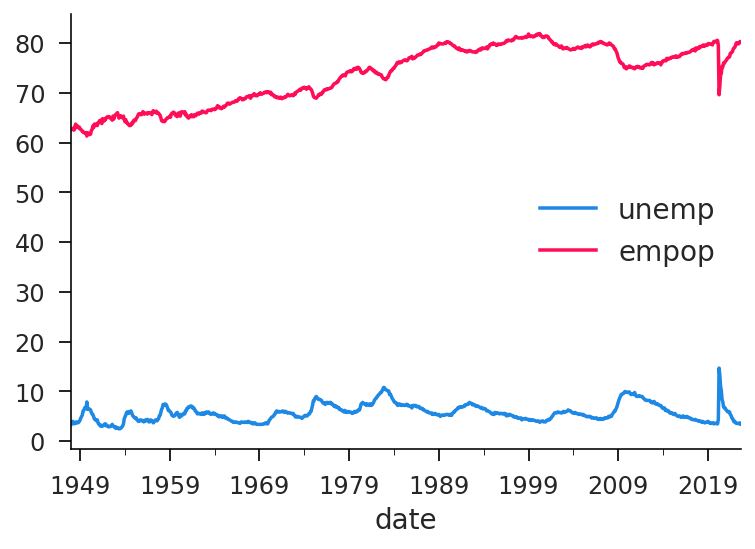

In [57]:
emp.plot();

In [58]:
# detrender
def detrend(s):
    name = s.name
    df = s.reset_index()
    df['year'] = df['date'].dt.year
    ret = smf.ols(f'{name} ~ 1 + year', data=df.reset_index()).fit()
    pred = pd.Series(ret.predict(), index=s.index)
    return s - pred

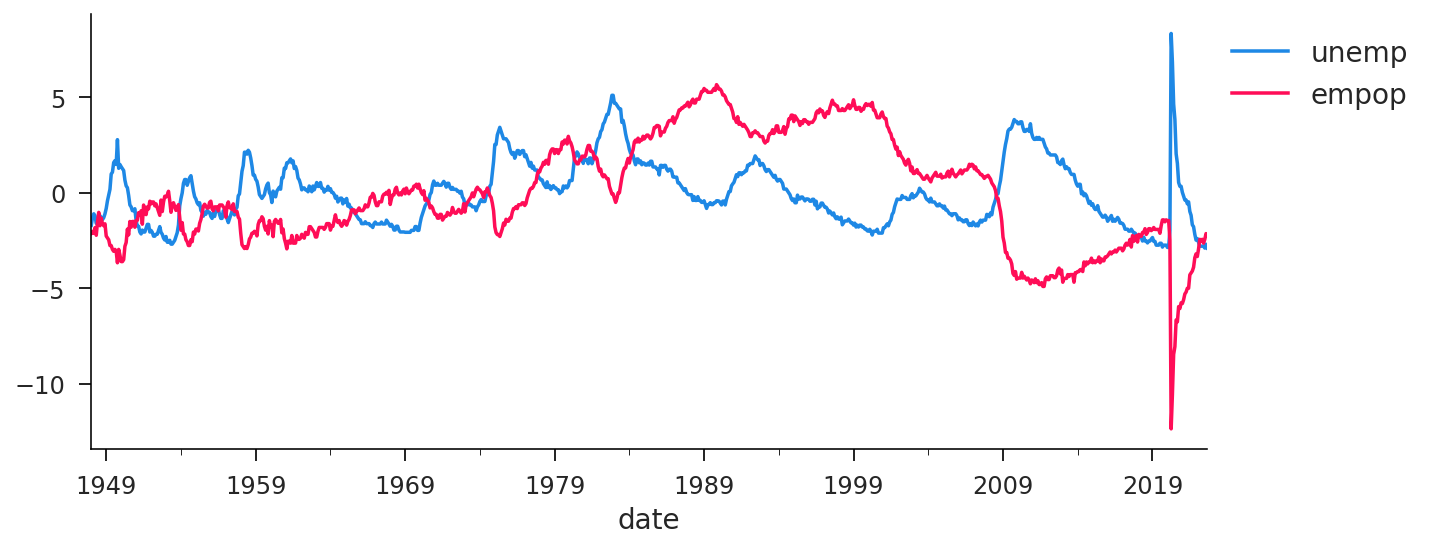

In [59]:
emp.apply(detrend).plot(figsize=(10, 4));
plt.legend(bbox_to_anchor=(1.0, 1.0));

In [60]:
# detrend poly!
def detrendn(s, deg=1):
    name = s.name
    df = s.reset_index()
    df['year'] = df['date'].dt.year
    df['zyear'] = df['year'] - df['year'].min()
    reg = []
    for n in range(deg+1):
        ds = f'year{n}'
        df[ds] = df['zyear']**n
        reg.append(ds)
    reg = f'{name} ~ ' + ' + '.join(reg)
    ret = smf.ols(reg, data=df).fit()
    pred = pd.Series(ret.predict(), index=s.index)
    return s - pred

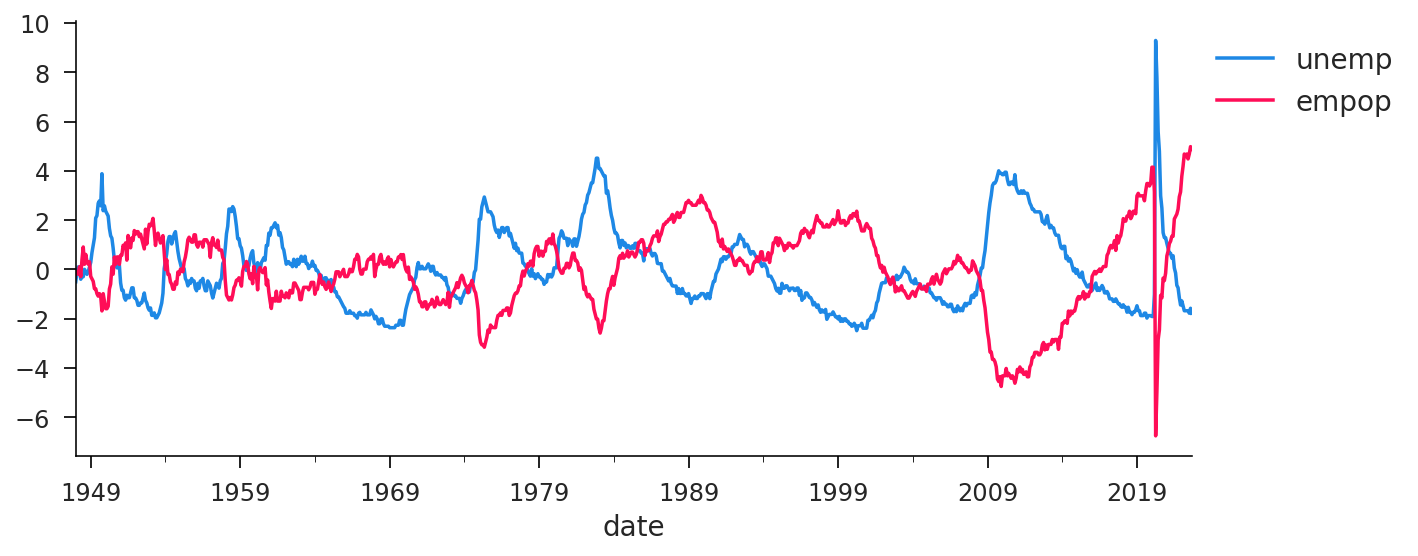

In [61]:
emp.apply(lambda s: detrendn(s, deg=3)).plot(figsize=(10, 4));
plt.legend(bbox_to_anchor=(1.0, 1.0));

In [62]:
# let's not reinvent the wheel
def detrendn1(s, deg=1):
    year = s.index.year
    zyear = year - year.min()
    coef = np.polyfit(zyear, s, deg)
    vals = np.polyval(coef, zyear)
    pred = pd.Series(vals, index=s.index, name=s.name)
    return s - pred

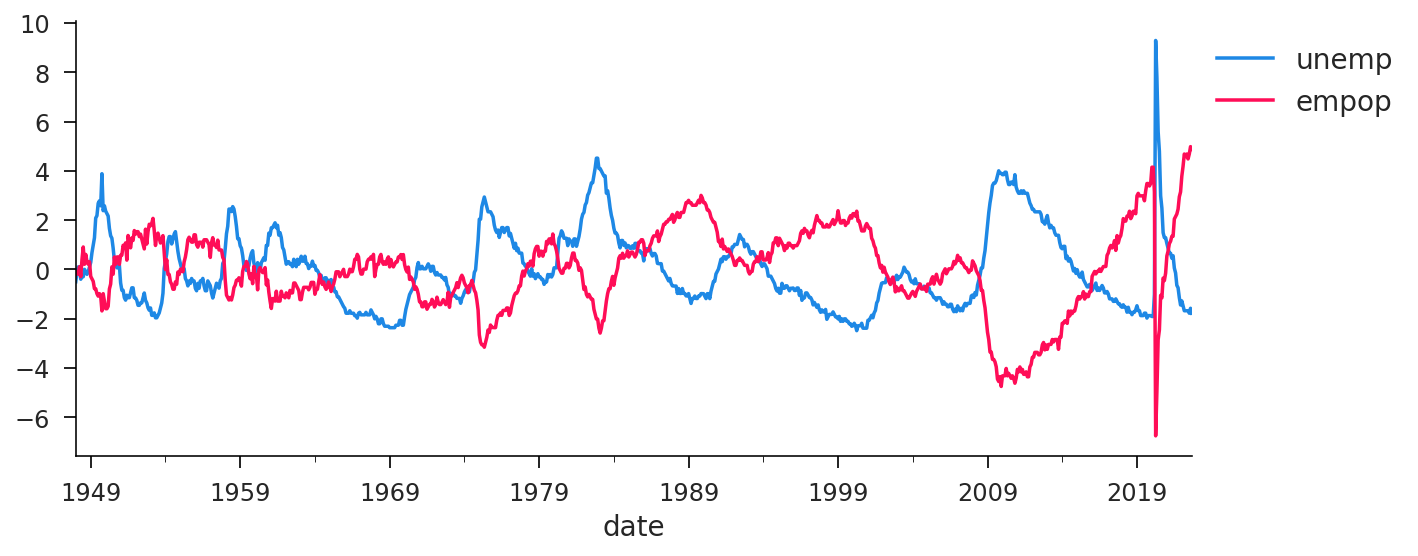

In [63]:
emp.apply(lambda s: detrendn1(s, deg=3)).plot(figsize=(10, 4));
plt.legend(bbox_to_anchor=(1.0, 1.0));

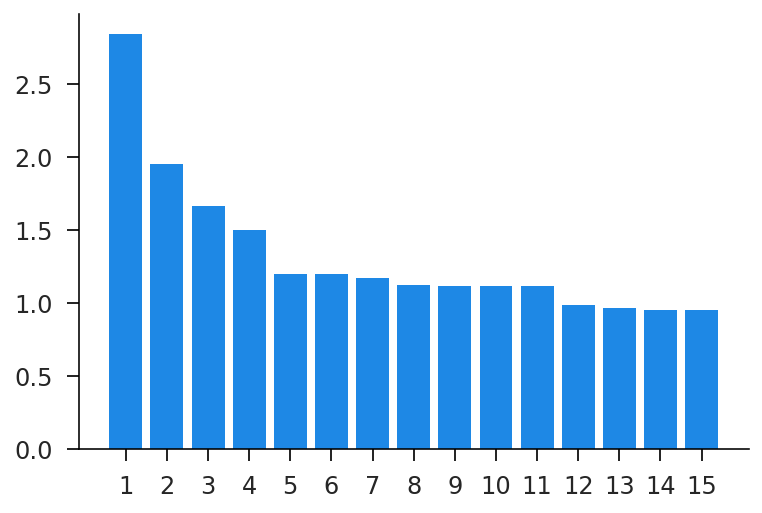

In [64]:
dvec = np.arange(1, 15+1)
plt.bar(dvec, [np.std(detrendn1(emp['empop'], deg=d)) for d in dvec]);
plt.xticks(dvec);

# Regressions

In [65]:
import statsmodels.formula.api as smf

## Basic

In [66]:
N = 100
x = np.random.randn(N)
y = 3*np.random.randn(N)
z = 1 + 2*x + 3*y + 4*x*y + np.random.randn(N)
df0 = pd.DataFrame({
    'x': x,
    'y': y,
    'z': z
})

In [67]:
ret = smf.ols('z ~ 1 + x + y', data=df0).fit()
ret.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      z   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     39.99
Date:                Tue, 25 Oct 2022   Prob (F-statistic):           2.15e-13
Time:                        14:42:47   Log-Likelihood:                -401.50
No. Observations:                 100   AIC:                             809.0
Df Residuals:                      97   BIC:                             816.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5199      1.362      1.116      0.267      -1.184       4.223
x              5.5368      1.296      4.272      0.000       2.965       8.109
y              3.2441      0.422      7.682      0.000       2.406       4.082
==============================================================================
Omnibus:                        8.357   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               16.710
Skew:                          -0.138   Prob(JB):                     0.000235
Kurtosis:                       4.983   Cond. No.                         3.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
ret.params

Intercept    1.519896
x            5.536763
y            3.244058
dtype: float64

In [69]:
ret = smf.ols('z ~ 1 + x*y', data=df0).fit()
ret.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      z   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.197e+04
Date:                Tue, 25 Oct 2022   Prob (F-statistic):          2.20e-123
Time:                        14:42:47   Log-Likelihood:                -135.22
No. Observations:                 100   AIC:                             278.4
Df Residuals:                      96   BIC:                             288.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8921      0.096      9.331      0.000       0.702       1.082
x              2.0449      0.094     21.702      0.000       1.858       2.232
y              3.0201      0.030    101.852      0.000       2.961       3.079
x:y            3.9575      0.028    140.125      0.000       3.901       4.014
==============================================================================
Omnibus:                        1.391   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.499   Jarque-Bera (JB):                1.375
Skew:                           0.275   Prob(JB):                        0.503
Kurtosis:                       2.834   Cond. No.                         3.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Categorical

In [70]:
import fastreg as fr
from fastreg import I, R, C

In [71]:
# make some fake data
N = 100
block = np.random.randint(4, size=N)
cmean = np.array([0.1, 0.2, 0.3, 0.4])
cvars = np.array([0.2, 0.1, 0.5, 0.2])
value = cmean[block] + np.random.randn(N)*cvars[block]
df1 = pd.DataFrame({
    'block': block,
    'value': value
})

In [72]:
fr.ols(y=R.z, x=I+R.x+R.y, data=df0)

z,coeff,stderr,low95,high95,pvalue
I,1.519896,1.362151,-1.149871,4.189663,2.645053e-01
x,5.536763,1.296028,2.996595,8.076930,1.936384e-05
y,3.244058,0.422292,2.416381,4.071734,1.576517e-14


In [73]:
fr.ols(y=R.z, x=I+R.x+R.y+R.x*R.y, data=df0)

z,coeff,stderr,low95,high95,pvalue
I,0.892136,0.095613,0.704739,1.079534,0.0
x,2.044870,0.094226,1.860190,2.229550,0.0
y,3.020132,0.029652,2.962015,3.078249,0.0
x*y,3.957505,0.028243,3.902150,4.012860,0.0


In [74]:
fr.ols(y=R.value, x=I+C.block, data=df1)

value,coeff,stderr,low95,high95,pvalue
I,0.054914,0.059853,-0.062396,0.172224,3.588916e-01
block=1,0.154483,0.074407,0.008648,0.300319,3.787592e-02
block=2,0.415635,0.084645,0.249734,0.581536,9.092023e-07
block=3,0.338068,0.075249,0.190582,0.485554,7.034892e-06


## Bootstrapping

In [75]:
from sklearn.utils import resample

In [76]:
def gen_block_data(N, cmean, cvars):
    cmean = np.array(cmean)
    cvars = np.array(cvars)
    block = np.random.randint(len(cmean), size=N)
    value = cmean[block] + np.random.randn(N)*cvars[block]
    return pd.DataFrame({
        'block': block,
        'value': value
    })

In [77]:
N = 100
K = 1000
cmean = [0.1, 0.2, 0.3, 0.4]
cvars = [0.2, 0.1, 0.5, 0.2]
mygen = lambda: gen_block_data(N, cmean, cvars)
myy, myx = R.value, C.block(drop=fr.NONE)
data0 = mygen()
mysamp = lambda: resample(data0)

In [78]:
res = fr.ols(y=myy, x=myx, data=data0)
stderr_reg = res['stderr']

In [79]:
res = fr.ols(y=myy, x=myx, data=data0, stderr='hc3')
stderr_rob = res['stderr']

In [80]:
res = pd.DataFrame({i: fr.ols(y=myy, x=myx, data=mygen())['coeff'] for i in range(K)}).T
stderr_bsp0 = res.std()

In [81]:
res = pd.DataFrame({i: fr.ols(y=myy, x=myx, data=mysamp())['coeff'] for i in range(K)}).T
stderr_bsp = res.std()

In [82]:
pd.DataFrame({
    'stderr_reg': stderr_reg,
    'stderr_rob': stderr_rob,
    'stderr_bsp0': stderr_bsp0,
    'stderr_bsp': stderr_bsp
}).T

,block=0,block=1,block=2,block=3
stderr_reg,0.062830,0.052568,0.067865,0.051713
stderr_rob,0.044649,0.015376,0.146836,0.028504
stderr_bsp0,0.041310,0.020375,0.104727,0.038910
stderr_bsp,0.044129,0.015519,0.143481,0.028348


## Networks

In [83]:
import networkx as nx

In [84]:
df = pd.DataFrame({
    'src': np.random.randint(10, size=20),
    'dst': np.random.randint(10, size=20),
    'wgt': np.random.exponential(size=20)
})
df = df.drop_duplicates(subset=['src', 'dst'])
df = df.query('src != dst')
df.head()

,src,dst,wgt
0,6,3,0.633458
1,6,2,0.234948
2,5,1,1.241578
3,1,9,0.840637
4,0,7,0.433708


In [85]:
G = nx.Graph()
G.add_nodes_from(np.arange(10))
G.add_weighted_edges_from([(x['src'], x['dst'], x['wgt']) for i, x in df.iterrows()])
# G.add_weighted_edges_from(df[['src', 'dst', 'wgt']].values) # equivalent
G

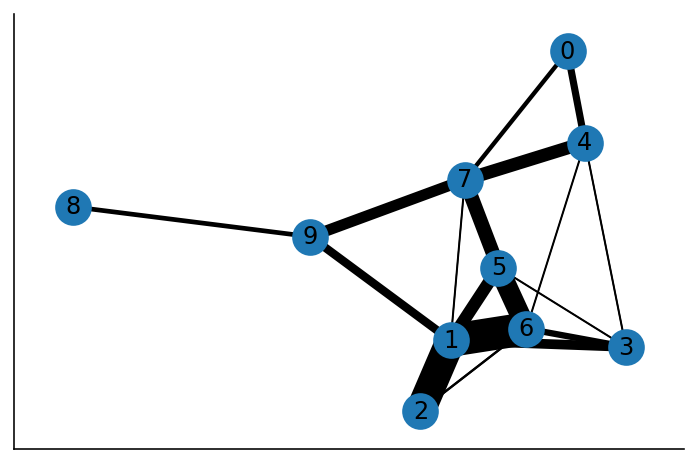

In [86]:
edgewidth = [5*d['weight'] for (u,v,d) in G.edges(data=True)]
pos = nx.spring_layout(G, iterations=50)
nx.draw_networkx(G, pos);
nx.draw_networkx_edges(G, pos, width=edgewidth);

In [87]:
nx.centrality.eigenvector.eigenvector_centrality(G, weight='weight')

{0: 0.017296664573368314,
 1: 0.6256375661017806,
 2: 0.3519681972339409,
 3: 0.17606196745847782,
 4: 0.04966118316835941,
 5: 0.3668844836193888,
 6: 0.5298184909776192,
 7: 0.1437210703021706,
 8: 0.010133331049995847,
 9: 0.12191190165155034}

## MAPS

You'll need some external data for this part. Head on over to: https://dataverse.harvard.edu/dataverse/chgis_v6. Then click on the "V6 Time Series Prefecture Polygons" element and download `v6_time_pref_pgn_utf_wgs84.zip` to the `data/china_maps_history` folder.

In [88]:
import geopandas as gpd
from ipywidgets import interact, IntSlider

In [89]:
pref_hist = gpd.read_file('data/china_maps_history/v6_time_pref_pgn_utf_wgs84.zip')
pref_hist = pref_hist.rename(columns={
    'NAME_CH': 'name_zh',
    'NAME_PY': 'name_en',
    'BEG_YR': 'beg_yr',
    'END_YR': 'end_yr'
})[['name_zh', 'name_en', 'beg_yr', 'end_yr', 'geometry']]
print(len(pref_hist))
pref_hist.head()

3830


,name_zh,name_en,beg_yr,end_yr,geometry
0,辽州,Liao Zhou,1151,1217,"POLYGON ((113.54941 36.75454, 113.54329 36.752..."
1,沁州,Qin Zhou,1129,1217,"MULTIPOLYGON (((112.00320 36.84234, 112.00954 ..."
2,霍州,Huo Zhou,1772,1911,"MULTIPOLYGON (((111.85910 36.44626, 111.86777 ..."
3,南泽州,Nanzhe Zhou,1128,1150,"POLYGON ((113.23645 35.44530, 113.22804 35.444..."
4,泽州,Zezhou Fu,1151,1217,"POLYGON ((113.23645 35.44530, 113.22804 35.444..."


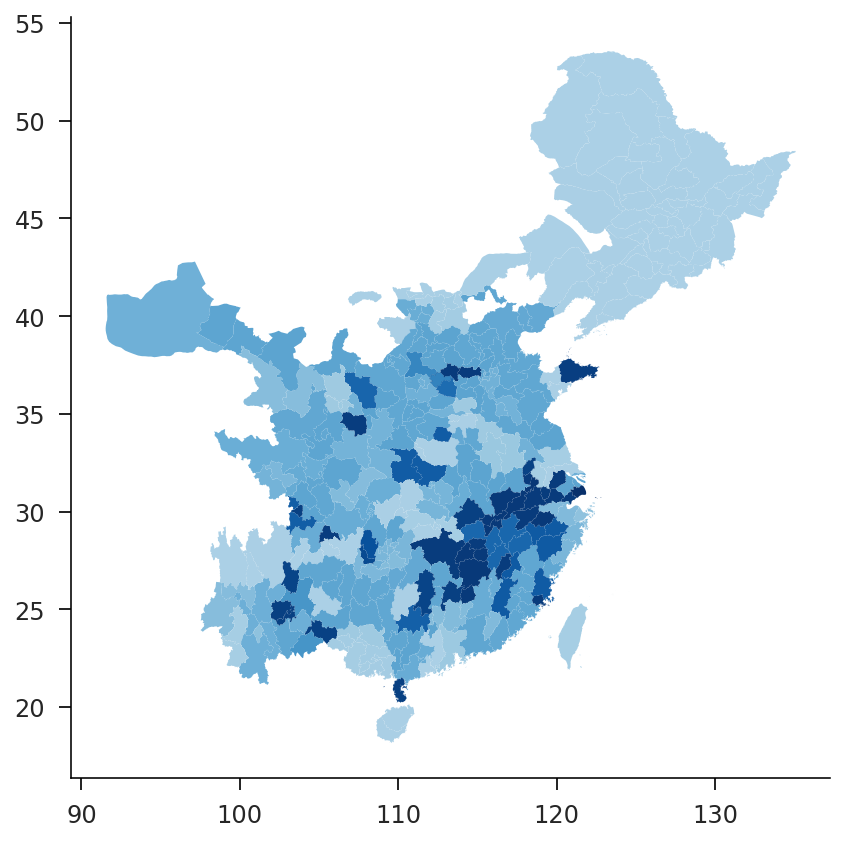

In [90]:
pref_1911 = pref_hist.query('beg_yr < 1911 and end_yr >= 1911')
pref_1911.plot(column='beg_yr', cmap='Blues_r', vmax=2200, figsize=(7, 7));

In [91]:
def plot_year(yr):
    df = pref_hist.query(f'beg_yr <= {yr} and end_yr >= {yr}')
    df['age'] = yr - df['beg_yr']
    yrmax = df['age'].max()
    fig, ax = plt.subplots(figsize=(7, 7))
    df.plot(column='age', cmap='Blues', ax=ax, vmin=-100, vmax=600);
    ax.set_xlim(85, 135)
    ax.set_ylim(15, 50)
    ax.set_aspect('equal')
interact(plot_year, yr=IntSlider(min=-224, max=1911, value=1900));

interactive(children=(IntSlider(value=1900, description='yr', max=1911, min=-224), Output()), _dom_classes=('w…

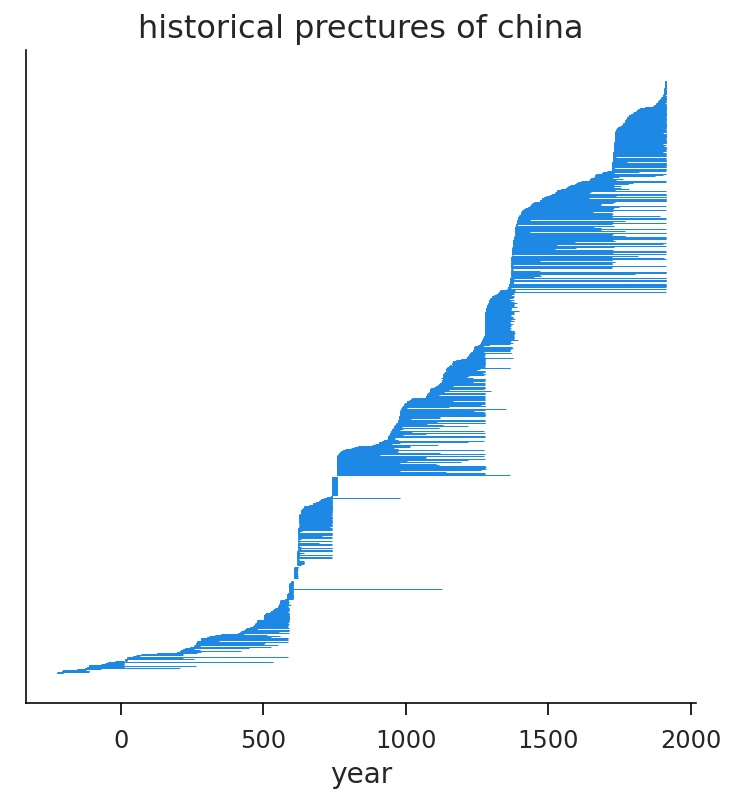

In [92]:
fig, ax = plt.subplots(figsize=(6, 6))
pref_range = pref_hist.sort_values('beg_yr')[['beg_yr', 'end_yr']].set_index(np.arange(len(pref_hist)))
for (i, (b, e)) in pref_range.iterrows():
    ax.hlines(i, b, e, linewidth=0.5)
ax.yaxis.set_visible(False);
ax.set_xlabel('year');
ax.set_title('historical prectures of china');

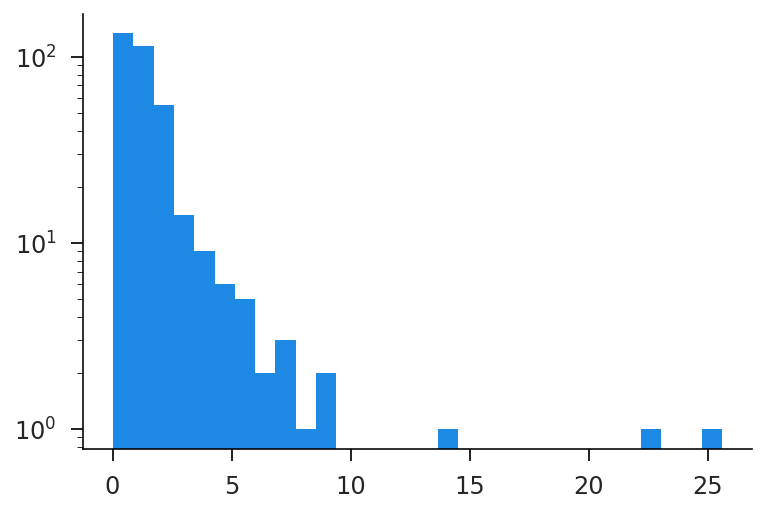

In [93]:
pref_hist.query('end_yr == 1911').area.hist(log=True, bins=30, grid=False);

### Advanced

Here you'll need the shapefiles for modern Chinese prefectures. Head on over to https://data.humdata.org/dataset/cod-ab-chn. Then download `chn_adm_ocha_2020_SHP.zip`, place it in the `data/china_maps_modern` directory, and unzip it.

In [94]:
year = 1776
pref_old = pref_hist.query(f'beg_yr <= {year} and end_yr >= {year}')
pref_old = pref_old[pref_old.is_valid]
pref_old.head()

,name_zh,name_en,beg_yr,end_yr,geometry
2,霍州,Huo Zhou,1772,1911,"MULTIPOLYGON (((111.85910 36.44626, 111.86777 ..."
184,郧阳府,Yunyang Fu,1476,1911,"POLYGON ((110.91881 31.66655, 110.90642 31.662..."
185,襄阳府,Xiangyang Fu,1476,1911,"POLYGON ((112.65113 31.66701, 112.65419 31.657..."
186,德安府,De'an Fu,1729,1911,"POLYGON ((113.91801 31.39151, 113.91645 31.384..."
187,汉阳府,Hanyang Fu,1763,1911,"POLYGON ((114.35085 30.68763, 114.35251 30.686..."


In [95]:
pref_new = gpd.read_file('data/china_maps_modern/chn_admbnda_adm2_ocha_2020.shp')
pref_new = pref_new.rename(columns={
    'ADM2_ZH': 'name_zh',
    'ADM2_EN': 'name_en',
})[['name_zh', 'name_en', 'geometry']]
pref_new.head()

,name_zh,name_en,geometry
0,克拉玛依市,Karamay,"POLYGON ((85.26975 45.29042, 85.29748 45.25837..."
1,昌吉回族自治州,Changji Hui Autonomous Prefecture,"POLYGON ((91.57898 45.05081, 91.53255 44.96698..."
2,石河子市[1],Shihezi,"POLYGON ((86.10937 44.26667, 86.11806 44.11220..."
3,锡林郭勒盟,Xilingol League,"POLYGON ((119.78428 46.64984, 119.86729 46.598..."
4,本溪市,Benxi,"POLYGON ((125.53547 40.92808, 125.46792 40.922..."


In [96]:
# choose a random modern prefecture
pref_samp = pref_new.query('name_zh == "成都市"')
name_zh, name_en = pref_samp.iloc[0][['name_zh', 'name_en']]
print(name_zh, name_en)

成都市 Chengdu


In [97]:
# efficiently find the intersection with old provinces
xmin, ymin, xmax, ymax = pref_samp.iloc[[0]].total_bounds
old_subset = pref_old.cx[xmin:xmax, ymin:ymax]
print(len(old_subset))
inter = gpd.overlay(old_subset[['name_en', 'name_zh', 'geometry']], pref_samp, how='intersection')
print(inter[['name_en_1', 'name_zh_1']].drop_duplicates())

9
      name_en_1 name_zh_1
0       Zi Zhou        资州
1    Chengdu Lu       成都府
2  Tongchuan Fu       潼川府
3      Mei Zhou        眉州
4    Qiong Zhou        邛州
5      Mao Zhou        茂州
6     Yazhou Fu       雅州府


In [98]:
from matplotlib import font_manager
font = font_manager.FontProperties()
font.set_family('Noto Sans CJK JP')
font.set_size(14)

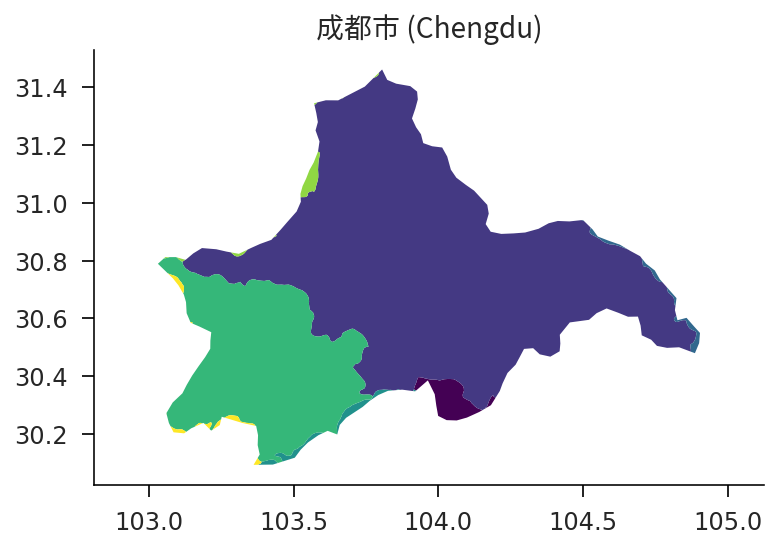

In [99]:
inter1 = inter[inter.area>0.001]
inter1['index'] = np.arange(len(inter1))
inter1.plot(column='index', cmap='viridis');
plt.title(f'{name_zh} ({name_en})', fontproperties=font);
plt.axis('equal');